In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from typing import *
import numpy as np
from functools import partial
from fastprogress import progress_bar
import pandas as pd
import h5py

from lumin.plotting.results import plot_roc

import torch
from torch import Tensor, nn
import torch.nn.functional as F
from torch._vmap_internals import _vmap as vmap

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
DEVICE = torch.device("cpu")

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

In [5]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 1.0
    init_res = 1e4
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0] if i in [0,3] else [0.5,0.5],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0] if i in [0,3] else [0.5,0.5],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [6]:
volume = Volume(get_layers())

In [7]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([1., 1.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([0.5000, 0.5000])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([0.5000, 0.5000])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([1., 1.])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=t

In [8]:
def sig_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z > 0.4 and z <= 0.5: rad_length[7:,6:] = X0['uranium']
    return rad_length

In [9]:
def bkg_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    return rad_length

In [12]:
volume.load_rad_length(sig_rad_length)

# Build dataset

In [13]:
def get_preds(volume:Volume) -> Tensor:
    gen = MuonGenerator2016.from_volume(volume)
    mus = MuonResampler.resample(gen(250), volume=volume, gen=gen)
    mu = MuonBatch(mus, init_z=volume.h)
    volume(mu)
    
    sb = ScatterBatch(mu, volume)
    inf = PanelX0Inferer(volume)
    inf.add_scatters(sb)
    vox_preds, weights = inf.get_prediction()
    return vox_preds

In [18]:
vox_preds = get_preds(volume)

In [19]:
vox_preds

tensor([[[0.1358, 0.0285, 0.0455, 0.0678, 0.0901, 0.3307, 0.0875, 0.0363,
          0.0397, 0.0416],
         [0.0737, 0.1492, 0.1195, 0.1199, 0.1271, 0.0644, 0.0560, 0.0438,
          0.0418, 0.0902],
         [0.0652, 0.0367, 0.0316, 0.0317, 0.0663, 0.0670, 0.0664, 0.0552,
          0.0964, 0.1163],
         [0.0775, 0.0410, 0.0846, 0.0996, 0.0245, 0.1346, 0.0847, 0.0460,
          0.0524, 0.2014],
         [0.0533, 0.0379, 0.0887, 0.0972, 0.0614, 0.0490, 0.1702, 0.0387,
          0.0390, 0.1819],
         [0.0439, 0.0709, 0.0922, 0.1151, 0.1793, 0.1246, 0.3383, 0.2195,
          0.2274, 0.1890],
         [0.1266, 0.1441, 0.0272, 0.1267, 0.4857, 0.3739, 0.2523, 0.0602,
          0.0964, 0.0671],
         [0.1306, 0.0763, 0.0648, 0.1117, 0.1208, 0.3717, 0.2556, 0.0035,
          0.0538, 0.0447],
         [0.1944, 0.0571, 0.0568, 0.1016, 0.1084, 0.0133, 0.0133, 0.0588,
          0.0605, 0.0482],
         [0.1731, 0.2372, 0.2719, 0.1647, 0.1170, 0.0892, 0.0203, 0.1336,
          0.0291,

In [24]:
panel = volume.get_detectors()[0].panels[0]

In [25]:
jacobian(vox_preds, panel.xy_span)

tensor([[[[ 1.6354e-02,  1.4231e-02],
          [ 1.2091e-03, -1.7837e-03],
          [ 5.1992e-03, -1.2129e-03],
          ...,
          [-2.7318e-03,  1.6537e-03],
          [-5.3292e-03,  9.9953e-04],
          [ 6.1992e-04,  2.2586e-04]],

         [[ 1.7347e-03,  3.0458e-03],
          [ 8.2802e-03, -1.1799e-03],
          [ 1.1169e-03, -2.4926e-03],
          ...,
          [-7.6037e-04,  5.9831e-05],
          [ 1.3754e-03,  3.3602e-03],
          [ 8.6078e-03,  7.4375e-03]],

         [[ 9.1028e-04,  4.6942e-04],
          [-6.7401e-04,  5.1133e-04],
          [-9.0630e-05, -4.3919e-05],
          ...,
          [ 1.8743e-06,  2.0485e-04],
          [ 1.2565e-02,  8.7245e-03],
          [-1.2593e-03, -2.3352e-04]],

         ...,

         [[-3.5453e-03,  2.1603e-02],
          [ 5.6408e-05, -6.6869e-04],
          [-1.0252e-03, -1.4837e-03],
          ...,
          [ 3.5047e-04,  3.7442e-04],
          [ 8.8953e-04, -1.3427e-04],
          [-1.1633e-05, -2.3482e-03]],

     

In [20]:
frac = 12/600

In [94]:
flat_preds = vox_preds.view(-1)

In [95]:
cut = flat_preds.kthvalue(1+round(frac*(flat_preds.numel()-1))).values

In [96]:
cut

tensor(0.0046, grad_fn=<KthvalueBackward0>)

In [97]:
jacobian(cut, panel.xy_span)

tensor([ 4.9704e-07, -3.6624e-05])

In [98]:
a = flat_preds[flat_preds>=cut].mean()

In [99]:
jacobian(a, cut)

AttributeError: 'NoneType' object has no attribute 'reshape'

In [100]:
vox_preds.min(), vox_preds.max()

(tensor(0.0006, grad_fn=<MinBackward1>),
 tensor(0.4857, grad_fn=<MaxBackward1>))

In [101]:
jacobian(a, panel.xy_span)

tensor([0.0023, 0.0041])

In [102]:
cut

tensor(0.0046, grad_fn=<KthvalueBackward0>)

In [137]:
c = cut.detach()

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


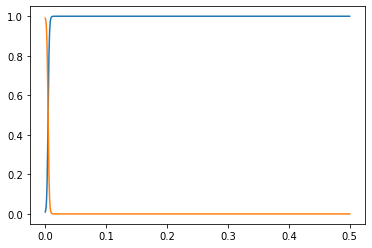

In [138]:
x = torch.linspace(0,0.5, 1000)
plt.plot(x, F.sigmoid(1000*(x-c)))
plt.plot(x, 1-F.sigmoid(1000*(x-c)))

In [139]:
wb =  F.sigmoid(10000*(flat_preds-cut))
ws =  1-wb

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [140]:
bm = flat_preds>=cut

In [141]:
ws[bm].mean(), wb[bm].mean()

(tensor(0.0014, grad_fn=<MeanBackward0>),
 tensor(0.9986, grad_fn=<MeanBackward0>))

In [142]:
ws[~bm].mean(), wb[~bm].mean()

(tensor(0.9413, grad_fn=<MeanBackward0>),
 tensor(0.0587, grad_fn=<MeanBackward0>))

In [143]:
a = (wb*flat_preds).sum()/wb.sum()

In [144]:
a, flat_preds[flat_preds>=cut].mean()

(tensor(0.1018, grad_fn=<DivBackward0>),
 tensor(0.1018, grad_fn=<MeanBackward0>))

In [145]:
jacobian(a, cut)

tensor(1.5066)

In [146]:
b = (ws*flat_preds).sum()/ws.sum()

In [147]:
b, flat_preds[flat_preds<cut].mean()

(tensor(0.0034, grad_fn=<DivBackward0>),
 tensor(0.0033, grad_fn=<MeanBackward0>))

In [148]:
jacobian(b, cut)

tensor(0.9105)

In [149]:
r = 2*(a-b)/(a+b)

In [150]:
jacobian(r, cut)

tensor(-31.6978)

In [151]:
jacobian(r, panel.xy_span)

tensor([0.0019, 0.0049])

In [152]:
pred = F.sigmoid((r-1)*5);pred

tensor(0.9874, grad_fn=<SigmoidBackward0>)

In [153]:
jacobian(pred, cut)

tensor(-1.9697)

In [154]:
jacobian(pred, panel.xy_span)

tensor([0.0001, 0.0003])

In [155]:
loss = F.binary_cross_entropy(pred, torch.ones_like(pred)); loss

tensor(0.0127, grad_fn=<BinaryCrossEntropyBackward0>)

In [156]:
jacobian(loss, cut)

tensor(1.9948)

In [157]:
jacobian(loss, panel.xy_span)

tensor([-0.0001, -0.0003])